In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from ruamel.yaml.scalarfloat import ScalarFloat

In [7]:
# creating paths
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-13' # 2
config_name = 'config_001.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_59999.pt' #  model_299999_hollowMLEProb.pt

#config_name = 'config_001_r07.yaml' 
#model_name = 'model_84999_hollowr07.pt' 
config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [12]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'ElboLBJF' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.loss.logit_type = 'reverse_prob'
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = False

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

number of parameters:  11358466
ema state dict function


In [13]:
n_samples = 25
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

500it [00:09, 54.56it/s]


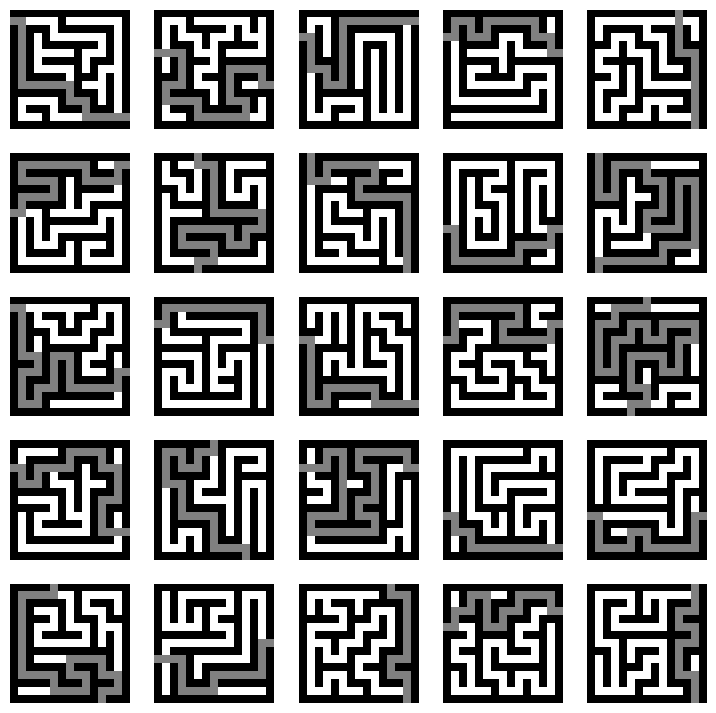

In [14]:
is_img = True

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
 
    saving_plot_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

[1.0, 0.7118222117424011, 0.5519999861717224, 0.454577773809433, 0.3731555640697479, 0.31040000915527344, 0.2757333219051361, 0.24977777898311615, 0.2227555513381958, 0.20586666464805603, 0.19253332912921906, 0.1708444505929947, 0.1683555543422699, 0.14328889548778534, 0.13777777552604675, 0.13724444806575775, 0.12800000607967377, 0.12035555392503738, 0.10453333705663681, 0.10755555331707001, 0.1068444475531578, 0.10293333232402802, 0.09315555542707443, 0.08604444563388824, 0.09546666592359543, 0.08444444835186005, 0.07644444704055786, 0.07395555824041367, 0.08035555481910706, 0.07395555824041367, 0.07111111283302307, 0.06346666812896729, 0.06400000303983688, 0.06382222473621368, 0.06275555491447449, 0.06400000303983688, 0.0567111112177372, 0.05955555662512779, 0.0556444451212883, 0.052088890224695206, 0.0536888912320137, 0.052977778017520905, 0.04924444481730461, 0.052444446831941605, 0.0545777790248394, 0.04800000041723251, 0.04942222312092781, 0.04391111060976982, 0.0463999994099140

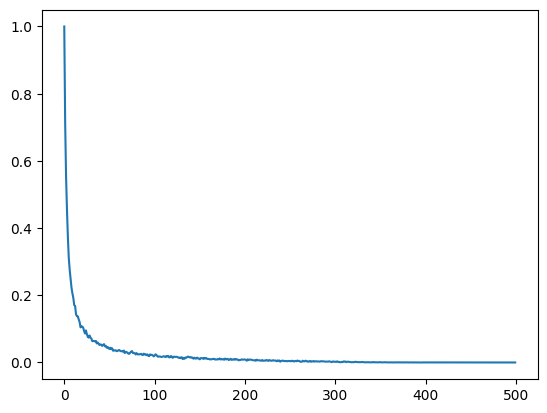

In [15]:
plt.plot(changes)
print(changes)
plt.show()